# Выбор локации для скважины

**Описание Проекта**

Вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

**Шаги для выбора локации:**

* В избранном регионе ищут месторождения, для каждого определяют значения признаков;  
* Строят модель и оценивают объём запасов;  
* Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;  
* Прибыль равна суммарной прибыли отобранных месторождений.

Вам предоставлены пробы нефти в трёх регионах: в каждом из 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Описание данных**

**Признаки**
* `id` — уникальный идентификатор скважины;

* `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);

**Целевой признак**
* `product` — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

*Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.*

## Загрузка и подготовка данных

### Импорт библиотек

In [1]:
# gentleman's set
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

import seaborn as sns
sns.set_theme(style="whitegrid")

# models
from sklearn.linear_model import LinearRegression

# metrics
from sklearn.metrics import mean_squared_error

# support
from sklearn.model_selection import train_test_split

# display
from IPython.display import display

### Импорт данных

In [2]:
try:  # local import
    df0 = pd.read_csv('./datasets/geo_data_0.csv')
    df1 = pd.read_csv('./datasets/geo_data_1.csv')
    df2 = pd.read_csv('./datasets/geo_data_2.csv')

except:  # local import is unavailable => import from Praktikum server
    df0 = pd.read_csv('/datasets/geo_data_0.csv')
    df1 = pd.read_csv('/datasets/geo_data_1.csv')
    df2 = pd.read_csv('/datasets/geo_data_2.csv')
    
data = [df0, df1, df2]

### Разведочный анализ данных

In [3]:
for idx, dataset in enumerate(data):
    print('====================')
    print(f'|| Dataset name: df{idx}, full duplicates: {dataset.duplicated().sum()}')
    display(dataset.head(10))
    dataset.info()
    print()

|| Dataset name: df0, full duplicates: 0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

|| Dataset name: df1, full duplicates: 0


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

|| Dataset name: df2, full duplicates: 0


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



In [4]:
def plot_matrix(dataset, idx):

    # Melt the dataset
    melt = pd.melt(dataset, id_vars=['product'], value_vars=['f0', 'f1', 'f2'],
                   var_name='feature', value_name='value')

    # Compute the correlation matrix
    corr = dataset.select_dtypes(include='number').corr()

    # Set up the matplotlib figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    fig.suptitle(f'df{idx} dataset visualization')

    # Draw the histogram – TOP LEFT
    axes[0, 0].set_title('Histogram plot')
    sns.histplot(melt, x='value', hue='feature', ax=axes[0, 0])

    # Draw the KDE plot – TOP RIGHT
    axes[0, 1].set_title('Kernel density estimate (KDE) plot')
    sns.kdeplot(data=melt.sample(1000), x="value", y="product",
                hue='feature', fill=True, alpha=0.5, legend=False, ax=axes[0, 1])

    # Draw the boxplot – BOTTOM LEFT
    axes[1, 0].set_title('Boxplot')
    sns.boxplot(data=melt, x="value", y='feature', ax=axes[1, 0])

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(20, 230, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio – BOTTOM RIGHT
    axes[1, 1].set_title('Corellation matrix')
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.2, cbar=False,
                annot=True, ax=axes[1, 1])

    print('='*106)
    return plt.show()

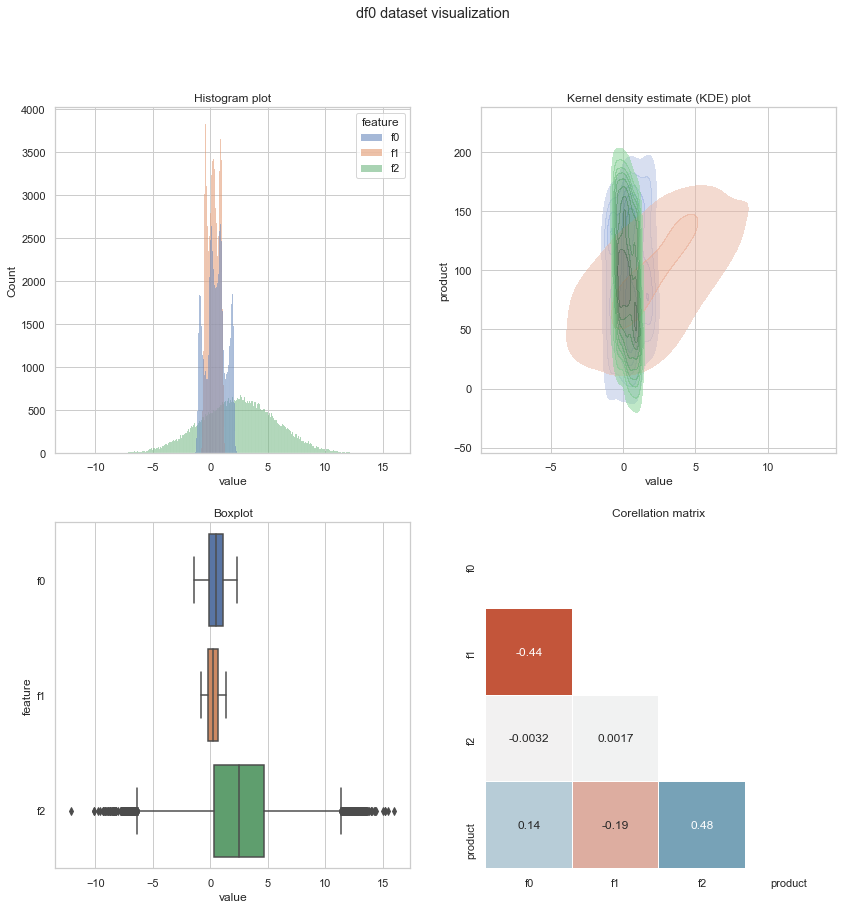

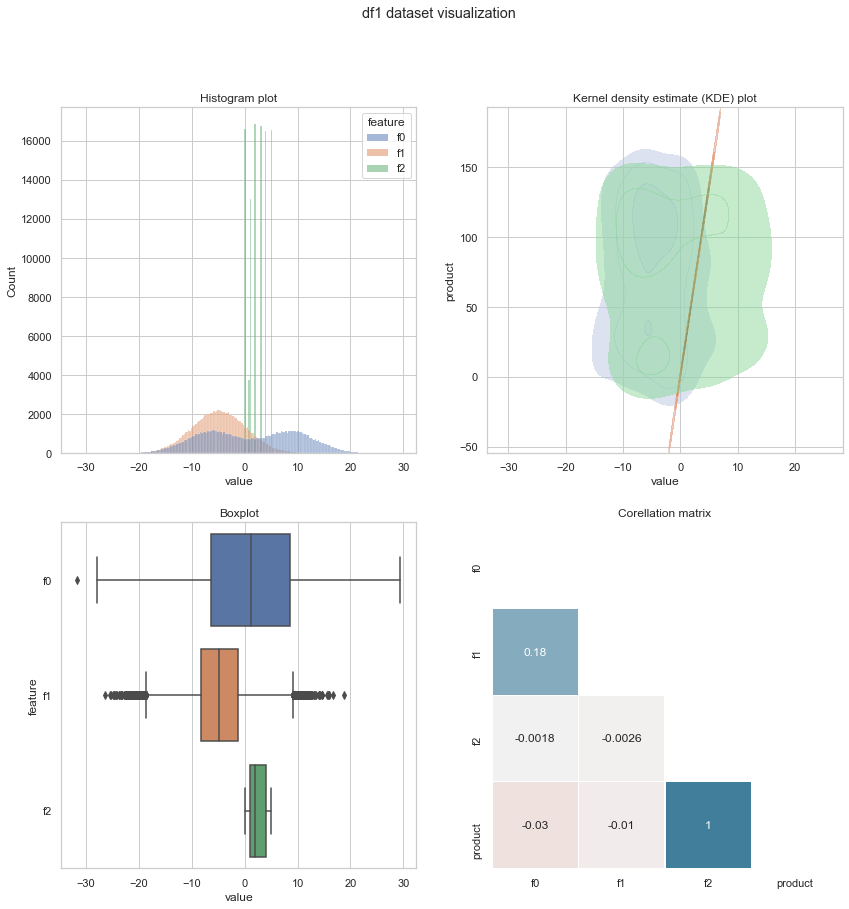

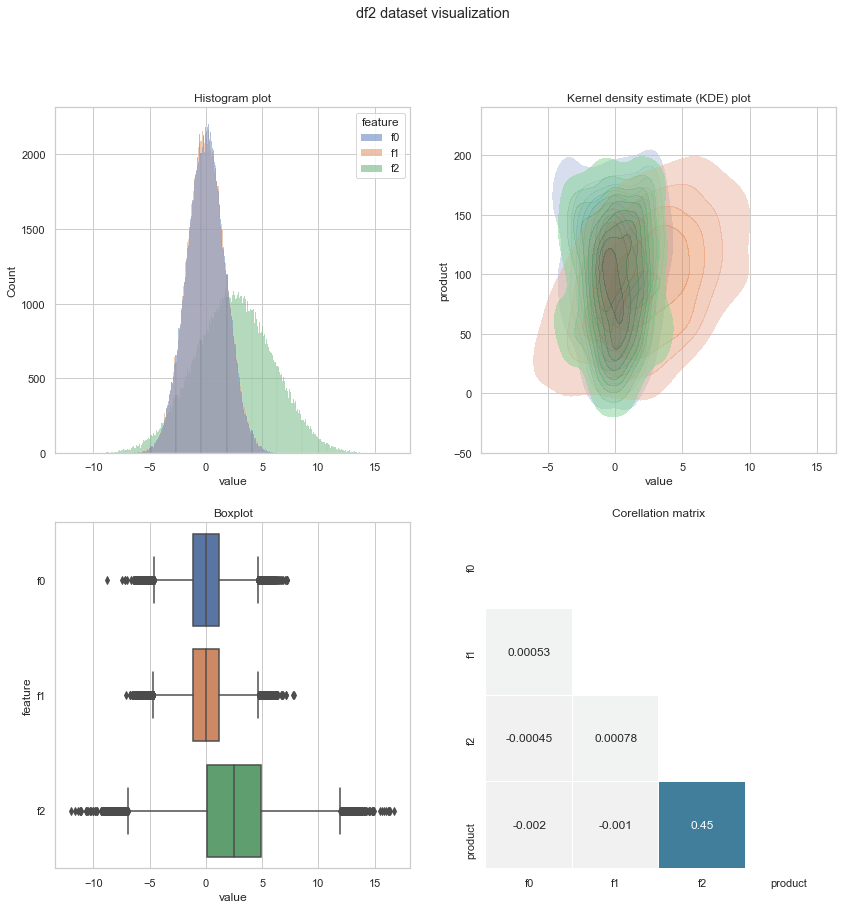

In [5]:
for idx, dataset in enumerate(data):
    plot_matrix(dataset, idx)

В случае с `df0` наблюдается мультиколлинеарность признаков. Явную корелляцию с `целевым признаком` имеет лишь признак `f2`.

## Обучение и проверка модели

In [6]:
def regression(dataset, idx):

    # Features select
    X = np.array(dataset.drop(['product', 'id'], axis=1))
    y = dataset['product']

    # Split
    X_train, X_test, y_train, y_actual = train_test_split(
        X, y, test_size=0.25, random_state=42)

    # Fit/Predict
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)

    # Evaluation
    rmse = round(np.sqrt(mean_squared_error(y_actual, y_predicted)), 2)
    avg_reserve_predicted = round(y_predicted.mean(), 2)
    avg_reserve_actual = round(y_actual.mean(), 2)

    return pd.DataFrame({'region': f'df{idx}',
                         'avg_reserve_actual': [avg_reserve_actual],
                         'avg_reserve_predicted': [avg_reserve_predicted],
                         'rmse': [rmse],
                         'y_actual': [y_actual.reset_index(drop=True)],
                         'y_predicted': [pd.Series(y_predicted)]})

In [7]:
estimate = pd.DataFrame()

for idx, dataset in enumerate(data):
    estimate = estimate.append(regression(dataset, idx)).reset_index(drop=True)

display(estimate.iloc[:, :4].sort_values(by=['rmse']))

,region,avg_reserve_actual,avg_reserve_predicted,rmse
1,df1,68.73,68.71,0.89
0,df0,92.33,92.40,37.76
2,df2,95.15,94.77,40.15


Модель построенная по региону `df1` имеет самую низкую оценку RMSE, а также наиболее низкую среднюю оценку запасов. Модели по двум другим регионам имеют существенно меньшую точность.

## Подготовка к расчёту прибыли

In [8]:
INVESTIGATED = 500
SELECTED = 200

BUDGET_PER_REGION = 10e9
BUDGET_PER_SITE = BUDGET_PER_REGION / SELECTED

BARREL_PRICE_1 = 450
BARREL_PRICE_1000 = BARREL_PRICE_1 * 1e3

RISK_THRESHOLD = '2.5%'

PAYBACK_THRESHOLD = round(BUDGET_PER_SITE / BARREL_PRICE_1000, 2)

In [9]:
print(f'Минимальный необходимый средний запас в месторождениях региона: {PAYBACK_THRESHOLD} тыс. баррелей.')

Минимальный необходимый средний запас в месторождениях региона: 111.11 тыс. баррелей.


In [10]:
estimate['avg_payback_delta'] = estimate['avg_reserve_actual'] - PAYBACK_THRESHOLD

print('Дельта средней оценки запаса по регионам, в порядке увеличения расхождения:')
display(round(estimate[['region', 'avg_payback_delta']].sort_values(by='avg_payback_delta', ascending=False), 2))

Дельта средней оценки запаса по регионам, в порядке увеличения расхождения:


,region,avg_payback_delta
2,df2,-15.96
0,df0,-18.78
1,df1,-42.38


* Минимальный средний запас в месторождениях региона для безубыточной разработки должен состовлять 111.11 тыс. баррелей.  


* Дельта средней оценки и минимального среднего запаса сырья, по регионам:
    * Регион `df2`: средний запас на 15.96 тыс. баррелей ниже порога окупаемости;
    * Регион `df0`: средний запас на 18,78 тыс. баррелей ниже порога окупаемости;
    * Регион `df1`: средний запас на 42,38 тыс. баррелей ниже порога окупаемости.
    
Таким образом, важной подзадачей разведки является обнаружение тех скважин, где предсказанный запас превысит среднюю оценку по региону не менее чем на 16-43 тыс. баррелей, и составит не менее 111.11 тыс. баррелей в абсолютных числах.

## Расчёт прибыли и рисков 

In [11]:
def revenue(target, probabilities, count):
    
    # GLOBAL const:
    # BARREL_PRICE_1000
    # BUDGET_PER_REGION

    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    revenue = selected.sum() * BARREL_PRICE_1000 - BUDGET_PER_REGION

    return int(revenue)

In [12]:
def bootstrap(target, probabilities, idx):
    
    # GLOBAL const:
    # INVESTIGATED
    # SELECTED

    state = np.random.RandomState(42)
    
    # Bootstrap
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=INVESTIGATED, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]
        
        result = revenue(target_subsample, probs_subsample, SELECTED)
        values.append(result)
    
    # Result
    values = pd.Series(values)

    # Output generation
    mean = int(round(values.mean(), 0))
    risk_rate = values[values < 0].count() / values.count()
    confidence_interval = [int(round(values.quantile(0.025), 0)),
                           int(round(values.quantile(0.975), 0))]   

    return pd.DataFrame({'revenue_mean': mean,
                         'risk_rate': ('{:.0%}').format(risk_rate),
                         'revenue_conf_interval': [confidence_interval]}, index=[idx])

In [13]:
temp = pd.DataFrame()

for idx, dataset in enumerate(data):

    temp = pd.concat([
        temp, bootstrap(
            estimate['y_actual'][idx],
            estimate['y_predicted'][idx],
            idx)
    ])

estimate = pd.concat([estimate, temp], axis=1)

In [14]:
display(estimate.drop(['y_actual', 'y_predicted'], axis=1).sort_values(by='revenue_mean', ascending=False))

,region,avg_reserve_actual,avg_reserve_predicted,rmse,avg_payback_delta,revenue_mean,risk_rate,revenue_conf_interval
1,df1,68.73,68.71,0.89,-42.38,511362776,1%,"[98870649, 940720511]"
0,df0,92.33,92.40,37.76,-18.78,427847560,6%,"[-97249829, 954215192]"
2,df2,95.15,94.77,40.15,-15.96,402575607,7%,"[-137162224, 929887528]"


**Вывод**: С учётом установленных рисков для безубыточной разработки подходит только регион `df1`.